In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn.mixture

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors


plt.rcParams.update({'font.size': 16, 'font.family': "Times New Roman",
                     'mathtext.fontset': 'cm', 'savefig.format' : 'pdf'})

In [2]:
# Define constants
proton_mass=938272088.16
electron_mass=510998.95
pmass= proton_mass+2*electron_mass
light_v=299792458

In [3]:
def interpolate_E(energy,Ncells):
    interpolated = []

    if Ncells>1:
        for i in range(len(energy) - 1):
            increment = (energy[i+1] - energy[i]) / Ncells
            for j in range(Ncells):
                interpolated.append(energy[i] + j * increment)
        interpolated.append(energy[-1])
    else:
        interpolated = energy
        
    return interpolated

In [4]:
def calc_dE(energy):
    dE = []
    if len(energy) >=2:
        for i in range(len(energy) - 1):
            dE.append(energy[i+1] - energy[i])
    dE.append(0)
    
    return dE

In [5]:
def calc_grad(energy,synch_phase):
    grad = np.divide(energy,np.cos(synch_phase/180*np.pi))
    
    return grad

In [6]:
def calc_gamma(energy,mass):
    gamma = np.divide(np.add(energy,mass),mass)
    
    return gamma

In [7]:
def calc_beta(gamma):
    beta = np.sqrt(1 - np.divide(1,gamma**2))
    
    return beta

In [8]:
def calc_L(beta,rf_freq,cavtype):
    light_v=299792458
    
    L=[]
    if cavtype=='SCL': 
        L = np.multiply(beta,light_v/rf_freq/2)
    elif cavtype=='DTL':
        L = np.multiply(beta,light_v/rf_freq)
    else:
        L = np.multiply(beta,light_v/rf_freq) # need to edit for fixed-lenght transition section
    
    #print(beta[:10],L[:10])
    return L

In [9]:
def make_section(cavtype,energy,synch_phase,mass,rf_freq,Ncells,Nmodules):
                 
    E = interpolate_E(energy,Ncells)
    dE = calc_dE(E)
    V = calc_grad(dE,synch_phase)
    G = calc_gamma(E,mass)
    B = calc_beta(G)
    L = calc_L(B,rf_freq,cavtype)
    
    df = pd.DataFrame({'Energy_cell' : E,
                      'dE' : dE,
                      'V' : V,
                      'Gamma' : G,
                      'Beta' : B,
                      'L' : L,
                      'Phi' : synch_phase,
                      'RF' : rf_freq,
                      'Type' : cavtype})
    if cavtype=='SCL':
        # Add drifts  
        for i in range(1,Nmodules):
            n=i*Ncells-1
            df.loc[n+0.5]=df.loc[n+1]
            df.loc[n+0.5,'V']=0
            df.loc[n+0.5,'dE']=0
            df.loc[n+0.5,'L']=float(df.loc[n+0.5,'L']*4)
        df = df.sort_index().reset_index(drop=True)
    
    return df

In [10]:
# Particle propagation

def propagate_Nturns(df,Nturns,init_phase,init_energy):
    
    E = []
    dE = []
    dPhi = []
    l = []

    T_synch=0
    T=0
    energy=0
    total_l=0
    
    for turn in range (0,Nturns):
        
        rf_freq = df.iloc[turn,df.columns.get_indexer(['RF'])].values[0]    
        synch_phase = df.iloc[turn,df.columns.get_indexer(['Phi'])].values[0]
        #synch_energy=df.iloc[turn+1,df.columns.get_indexer(['Energy_cell'])].values[0] #end of turn
        synch_energy=df.iloc[turn,df.columns.get_indexer(['Energy_cell'])].values[0]
        cavtype = df.iloc[turn,df.columns.get_indexer(['Type'])].values[0]
    
        if turn==0:
            T_synch=0
            T=(init_phase - synch_phase)/360.0/rf_freq
            energy=init_energy
            
            dPhi.append(init_phase - synch_phase)
            dE.append(init_energy - synch_energy)
            E.append(init_energy)
            l.append(0)
                    
        
        voltage=df.iloc[turn,df.columns.get_indexer(['V'])].values[0]
        length=df.iloc[turn,df.columns.get_indexer(['L'])].values[0]
 
        total_l=total_l+length

        gamma=(pmass+energy)/pmass
        beta=np.sqrt(1-1/gamma/gamma)
        
        # advance T_synch
        if cavtype=='SCL':
            if voltage==0:
                T_synch = T_synch + 2.0*(1/rf_freq)
            else:
                T_synch = T_synch + 0.5*(1/rf_freq)
        elif cavtype=='DTL':
            if voltage==0:
                T_synch = T_synch + 1/rf_freq ##need to fix - no DTL drift now
            else:
                T_synch = T_synch + 1/rf_freq
                
        else:
            T_synch = T_synch + 21*1/rf_freq ## need to fix
        
        # advance T        
        T=T+length/(beta*light_v)
        
        
        phase_deg = T*rf_freq*360 # T/(1/rf_freq)*2*np.pi*(180/np.pi)

        del_phase =(T-T_synch)*rf_freq*2*np.pi
        energy = energy + voltage*np.cos((synch_phase/180*np.pi)+del_phase)
        synch_energy = synch_energy + voltage*np.cos((synch_phase)/180*np.pi)
        
        del_energy=energy-synch_energy
        del_phase_deg=del_phase*180/np.pi

        dPhi.append(del_phase_deg)
        dE.append(del_energy)
        E.append(energy)
        l.append(total_l)
     
    particle_prop = pd.DataFrame({'E':E,'dE':dE, 'dPhi':dPhi,'l':l})

    return particle_prop


In [11]:
def gen_scan_range(lims,stepsize):
    
    Nsteps = int(abs(lims[1]-lims[0])/stepsize)+1
    scan_range = np.linspace(lims[0],lims[1],Nsteps,endpoint=True)
    
    return scan_range

In [12]:
def phase_scan(scan_range,df,Nturns,e_offset,ph_offset):
    
    initE = []
    endE = []
    initPhi = []
    endPhi = []
    #parts = []
    init_energy = df['Energy_cell'].iloc[0]
    
    for ph in scan_range:
        dfp = propagate_Nturns(df,Nturns,ph+ph_offset,init_energy+e_offset)
        initE.append(dfp['E'].iloc[0])
        endE.append(dfp['E'].iloc[-1])
        initPhi.append(dfp['dPhi'].iloc[0])
        endPhi.append(dfp['dPhi'].iloc[-1])
        #parts.append(dfp)

    cav_response = pd.DataFrame({'cavPhi': scan_range,'initE' : initE, 'endE': endE, 
                                 'initPhi' : initPhi, 'endPhi' : endPhi})

    return cav_response

In [13]:
def chi2_scan(e_offset_range,ph_offset_range,ph_range,df,Nturns,dfdata):
    
    chi2s = []
    cavs = []
    
    # dispersion factors
    D = [-0.4997,-2.224,-1.406]#,0.98]
    var = ['B:HPQ3_E','B:HPQ4_E','B:HPQ5_E']#,'B:VPQ5_E'] ## Effect of autosteer on VPQ5 needs investigation 
    
    for p in ph_offset_range:
        print(p)
        for e in e_offset_range:
            cav_response = phase_scan(ph_range,df,Nturns,e,p)
            cavs.append(cav_response)
            
            # If data & sim have same phase scan range and step size, we can do vector math
            diffs =[((cav_response['endE'] - dfdata[v])**2).sum()/(d**2) for v,d in zip(var,D)]            
            chi2s.append(np.sum(diffs))
            
            # If not we need to do point-wise calculation - uncomment below
            #chi2tot = 0
            #for pp in ph_range:
            #    chi2 = 0
            #    sim = cav_response['endE'].loc[(np.abs(cav_response['initPhi']-pp)<0.2)].iloc[0]
            #    dfslice = dfdata.loc[(np.abs(dfdata['L:L7PADJ']-pp)<0.2)].iloc[0]
            #    for j,d in enumerate(D):
            #        chi2= chi2 +(dfslice[var[j]] - sim)**2/(d**2)
            #    chi2tot = chi2tot+chi2     
            #chi2s.append(chi2tot)       

    return cavs,chi2s

In [14]:
def multi_phase_scan(e_offset_range,ph_offset_range,ph_range,df,Nturns):
    
    cavs = []
    
    for p in ph_offset_range:
        print(p)
        for e in e_offset_range:
            cav_response = phase_scan(ph_range,df,Nturns,e,p)
            
            cavs.append(cav_response)

    return cavs

In [15]:
def extract_dx(cavs):
    
    # dispersion factors
    D = [-0.4997,-2.224,-1.406]#,0.98]
    var = ['B:HPQ3','B:HPQ4','B:HPQ5']#,'B:VPQ5'] ## Effect of autosteer on VPQ5 needs investigation 

    for cav in cavs:

        Eref = cav['endE'].loc[cav['cavPhi']==0].values[0]
        deltaE = cav['endE'] - Eref
        E_t = Eref + 938e6 # pmass

        gamma = E_t/938e6
        beta = np.sqrt(1-(1/gamma)*(1/gamma))

        for i,v in enumerate(var):
            cav[v]= 1000*D[i]*deltaE/E_t/beta/beta 
        

    return(None)

In [16]:
def circle_points(r, n):
    circles = []
    for r, n in zip(r, n):
        t = np.linspace(0, 2*np.pi, n, endpoint=False)
        x = r * np.cos(t)
        y = r * np.sin(t)
        circles.append(np.c_[x, y])
    return circles


initE = 357.1e6 #eV                                                                                                                                          
initPhi = -32 #deg                                                                                                                                        

r = [20] #delta phi in degrees, can take multiple entries                                                                                              
rE = [0.002e6] #delta E in MeV, can take multiple                                                                                                        
n = [10] # number of particles on circle, can take multiple                                                                                          

circles = circle_points(r, n)
#fig, ax = plt.subplots()

# 2D Gaussian
samples = np.random.multivariate_normal([initPhi, initE], [[r[0]**2/4., 1],[1, rE[0]**2/4.]], n[0])

#ax.scatter(samples[:,0],samples[:,1],label='2D Gauss')

for i,circle in enumerate(circles):
    enes = np.add(circle[:,1]/(r[i]/rE[i]),initE)
    phases = np.add(circle[:,0],initPhi)

    #ax.scatter(phases,enes,label='circle')

#fig.legend()

In [17]:
def fetch_data(file,datacols,cuts,setdevs):
    dataset = pd.read_csv(file)
    dataset.columns = dataset.columns.str.replace("[()]", "_",regex=True)

    cols = list(dataset.filter(regex='|'.join(datacols)))

    # for set points, keep _S_ and drop _R_ if available
    cols = [col for col in cols for word in setdevs if col.find(word)==-1]
    
    subset = dataset.loc[:,cols]
    subset.columns = subset.columns.str.replace("_R_|_S_", "",regex=True)
    subset.drop(list(subset.filter(regex=r'\.1|Time|step|iter')),axis=1, inplace=True)

    # apply data quality cuts
    subset.query(cuts,inplace=True)
    
    # augment jumps in phase data
    #subset['B:BQ3F'] = subset['B:BQF3'].apply(lambda x : x if x > 0 else x +360)
    subset.dropna()
    
    print(subset.head())
    
    return subset

In [18]:
# SCL Energy and energy gain per cell from design
energy = np.multiply([357.1,368.1,379.1,390.2,401.5],1e6)

In [19]:
df = make_section('SCL',energy,-32,pmass,805e6,16,4)
df.head(10)
df.tail(10)

,Energy_cell,dE,V,Gamma,Beta,L,Phi,RF,Type
58,395143750.0,706250.0,832794.747374,1.420682,0.710311,0.132265,-32,805000000.0,SCL
59,395850000.0,706250.0,832794.747374,1.421434,0.710680,0.132333,-32,805000000.0,SCL
60,396556250.0,706250.0,832794.747374,1.422185,0.711048,0.132402,-32,805000000.0,SCL
61,397262500.0,706250.0,832794.747374,1.422937,0.711415,0.132470,-32,805000000.0,SCL
62,397968750.0,706250.0,832794.747374,1.423689,0.711782,0.132538,-32,805000000.0,SCL
63,398675000.0,706250.0,832794.747374,1.424441,0.712148,0.132607,-32,805000000.0,SCL
64,399381250.0,706250.0,832794.747374,1.425193,0.712513,0.132674,-32,805000000.0,SCL
65,400087500.0,706250.0,832794.747374,1.425945,0.712877,0.132742,-32,805000000.0,SCL
66,400793750.0,706250.0,832794.747374,1.426697,0.713240,0.132810,-32,805000000.0,SCL
67,401500000.0,0.0,0.000000,1.427449,0.713603,0.132877,-32,805000000.0,SCL


    L:L7PADJ    L:D64BF     L:D74BF    B:HPQ3    B:HPQ4    B:HPQ5    B:VPQ5
0  72.006226  43.341064  112.999878  4.104026  4.708936  5.679242  3.479065
1  72.006226  43.104858  113.236084  4.184235  4.683313  5.556700  3.401084
2  72.006226  43.132324  113.269043  4.097342  4.629841  5.619085  3.430048
3  72.006226  43.203735  113.708496  4.101798  4.783575  5.704864  3.461240
4  72.006226  42.994995  113.796387  4.189805  4.810311  5.656961  3.515827
    L:L7PADJ    L:D64BF     L:D74BF    B:HPQ3    B:HPQ4    B:HPQ5    B:VPQ5
0  72.006226  44.159546  106.875000  3.285226  1.516173  4.042756  5.795099
1  72.006226  44.132080  113.483276  4.029387  4.920598  6.213968  4.154157
2  72.006226  44.340820  113.032837  3.971459  4.687770  6.036840  4.371390
3  72.006226  44.247437  113.389893  4.018247  4.882722  6.212854  4.245506
4  72.006226  44.247437  113.389893  4.098456  5.019746  6.193916  4.253304


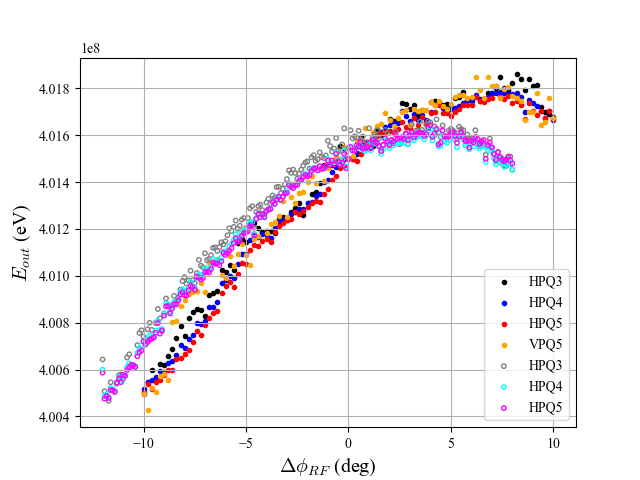

In [28]:
%matplotlib widget

file=r'~/Desktop/LINAC_STUDY/BEAM STUDY 22FEB2023 C7PHAS/devicescanFeb22_2023_72to92.csv'
file2=r'~/Desktop/LINAC_STUDY/BEAM STUDY 20FEB2023/devicescan_TrainingData_Feb202023.csv'

dataset1 = fetch_data(file,['L7PADJ','HPQ3','HPQ4','HPQ5','VPQ5','D64BF','D74BF'],'`L:L7PADJ`>54 & `L:L7PADJ`<96',['L7PADJ_R'])
#subtract reference 
ref = (dataset1.loc[(np.abs(dataset1['L:L7PADJ']-82.)<0.205) & (dataset1['L:L7PADJ']>=82.)]).mean()

dataset1 = dataset1 - ref

dataset2 = fetch_data(file2,['L7PADJ','HPQ3','HPQ4','HPQ5','VPQ5','D64BF','D74BF'],'`L:L7PADJ`>54 & `L:L7PADJ`<96',['L7PADJ_R'])
ref2 = (dataset2.loc[(np.abs(dataset2['L:L7PADJ']-84.)<0.105) & (dataset2['L:L7PADJ']>=84.)]).mean()
dataset2 = dataset2 - ref2

#print(ref)
#print(ref2)

D = [-0.4997,-2.224,-1.406,0.98]
E_kin=401.5e6
E_t=E_kin+938e6
beta=0.7136

dataset1['B:HPQ3_E']=dataset1['B:HPQ3']/1000/D[0]*beta*beta*E_t+E_kin
dataset1['B:HPQ4_E']=dataset1['B:HPQ4']/1000/D[1]*beta*beta*E_t+E_kin
dataset1['B:HPQ5_E']=dataset1['B:HPQ5']/1000/D[2]*beta*beta*E_t+E_kin
dataset1['B:VPQ5_E']=dataset1['B:VPQ5']/1000/D[3]*beta*beta*E_t+E_kin

dfavg= dataset1.groupby(np.arange(len(dataset1))//10).mean()

dataset2['B:HPQ3_E']=np.add(dataset2['B:HPQ3'],-0.03)/1000/(D[0]*0.92)*beta*beta*E_t+E_kin
dataset2['B:HPQ4_E']=dataset2['B:HPQ4']/1000/(D[1]*0.99999)*beta*beta*E_t+E_kin
dataset2['B:HPQ5_E']=dataset2['B:HPQ5']/1000/(D[2]*0.9999)*beta*beta*E_t+E_kin
dataset2['B:VPQ5_E']=dataset2['B:VPQ5']/1000/D[3]*beta*beta*E_t+E_kin

dfavg2= dataset2.groupby(np.arange(len(dataset2))//10).mean()

plt.scatter(dfavg['L:L7PADJ'],dfavg['B:HPQ3_E'], label='HPQ3',marker='.',color='k')
plt.scatter(dfavg['L:L7PADJ'],dfavg['B:HPQ4_E'], label='HPQ4',marker='.',color='b')
plt.scatter(dfavg['L:L7PADJ'],dfavg['B:HPQ5_E'], label='HPQ5',marker='.',color='r')
plt.scatter(dfavg['L:L7PADJ'],dfavg['B:VPQ5_E'], label='VPQ5',marker='.',color='orange')

plt.scatter(dfavg2['L:L7PADJ'],dfavg2['B:HPQ3_E'], label='HPQ3',marker='o',s=10,color='grey',facecolors='none')
plt.scatter(dfavg2['L:L7PADJ'],dfavg2['B:HPQ4_E'], label='HPQ4',marker='o',s=10,color='cyan',facecolors='none')
plt.scatter(dfavg2['L:L7PADJ'],dfavg2['B:HPQ5_E'], label='HPQ5',marker='o',s=10,color='magenta',facecolors='none')
#plt.scatter(dfavg2['L:L7PADJ'],dfavg2['B:VPQ5_E'], label='VPQ5',marker='o',color='orange',facecolors='none')

plt.xlabel('$\Delta\phi_{RF}$ (deg)',fontsize='x-large')
plt.ylabel('$E_{out}$ (eV)',fontsize='x-large')
plt.legend(loc='lower right')
#plt.xlim(-10,10)
#plt.ylim(400e6,403e6)
plt.grid()



In [21]:
stepsize = dfavg['L:L7PADJ'].iloc[1] - dfavg['L:L7PADJ'].iloc[0]
stepsize = round(stepsize,2)
print(stepsize)
phaserange = gen_scan_range([-10,10],stepsize)
#Eoff_range = gen_scan_range([-5.7e6,-5.5e6],0.05e6)
Eoff_range = gen_scan_range([-6.75e6,-6.55e6],0.05e6)
Phioff_range = gen_scan_range([-29.6,-29.0],0.10)

#print(phaserange, len(phaserange))
print(Eoff_range, Phioff_range)

0.2
[-6750000. -6700000. -6650000. -6600000. -6550000.] [-29.6 -29.5 -29.4 -29.3 -29.2 -29.1 -29. ]


In [22]:
%%time
cavres1,chi1 = chi2_scan(Eoff_range, Phioff_range, phaserange, df, 67, dfavg)

-29.6
-29.5
-29.400000000000002
-29.3
-29.2
-29.1
-29.0
CPU times: user 2min 59s, sys: 3.66 s, total: 3min 3s
Wall time: 3min


17
    cavPhi        initE          endE  initPhi     endPhi
48    -0.4  350450000.0  4.015193e+08      2.3  43.210890
49    -0.2  350450000.0  4.015337e+08      2.5  43.246247
50     0.0  350450000.0  4.015478e+08      2.7  43.283734
51     0.2  350450000.0  4.015615e+08      2.9  43.323363


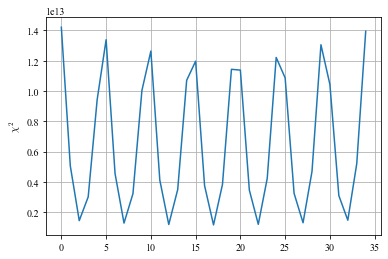

In [23]:
%matplotlib inline

plt.plot(chi1)
plt.ylabel('$\chi^{2}$')
plt.grid()

print(np.argmin(chi1))
print(cavres1[np.argmin(chi1)].iloc[48:52])

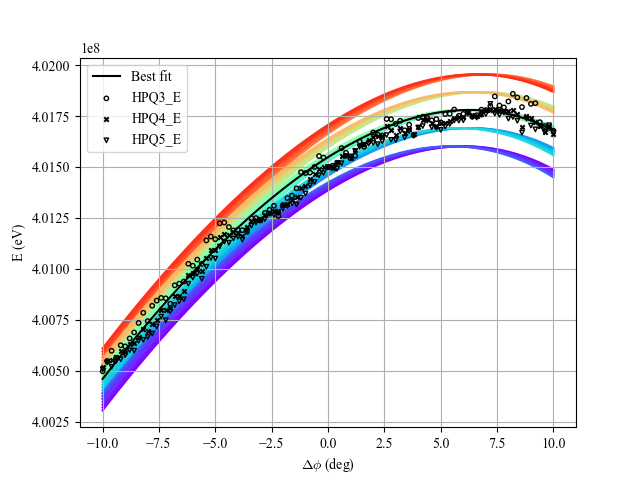

In [24]:
%matplotlib widget

colors = plt.cm.rainbow(np.linspace(0, 1, len(Eoff_range)*len(Phioff_range)))
cols = [colors[i*len(Phioff_range):(i+1)*len(Phioff_range)] for i in range(len(Eoff_range))]

for i,cav in enumerate(cavres1):
    plt.plot(cav['cavPhi'],cav['endE'],linestyle='-',color=cols[i%len(Eoff_range)][int(i/len(Phioff_range))],zorder=1)

plt.plot(cavres1[np.argmin(chi1)]['cavPhi'],cavres1[np.argmin(chi1)]['endE'],linestyle='-',label='Best fit',zorder=2, color='k')

plt.scatter(dfavg['L:L7PADJ'],dfavg['B:HPQ3_E'],marker='o',s=10,facecolors='none',color='k',label='HPQ3_E',zorder=3)
plt.scatter(dfavg['L:L7PADJ'],dfavg['B:HPQ4_E'],marker='x',s=10,color='k',label='HPQ4_E',zorder=3)
plt.scatter(dfavg['L:L7PADJ'],dfavg['B:HPQ5_E'],marker='v',s=10,facecolors='none',color='k',label='HPQ5_E',zorder=3)
#plt.scatter(dfavg['L:L7PADJ'],dfavg['B:VPQ5_E'],marker='s',s=10,facecolors='none',color='k',label='VPQ5_E',zorder=3)


plt.legend()
plt.xlabel('$\Delta \phi$ (deg)')
plt.ylabel('E (eV)')
plt.grid()
